# Mosaicos

1. [Introdução](#introducao)
2. [Implementação](#implementacao)
3. [Mosaicos](#mosaicos)
<a name="introducao"></a>

## Introdução

Um mosaico pode ser construído utilizando várias imagens de uma mesma cena tiradas a partir de uma mesma posição, rotacionando a câmera. A colagem das imagens pode ser feita calculando a homografia entre um plano de uma imagem e da imagem de destino. Os pontos iguais entre as duas imagens, que servirão de parâmetros para a homografia, podem ser encontrados por meio do match de keypoints.

No trabalho será realizado o mosaico de 3 conjuntos de 3 imagens, usando o match de keypoints SIFT com descritores SIFT e BRIEF.

As imagens foram reduzidas para 30% do tamanho original no upload e 15% do tamanho original na execução.

<a name="implementacao"></a>

## Implementação

A implementação do mosaico se deu pelas seguintes etapas:
Primeiro foram carregados os conjuntos de imagens (É entendido que os conjuntos estão no arquivo sets.zip, que gera uma pasta imgs contendo cada um dos sets), depois para cada um dos conjuntos é realizada a detecção e descrição de keypoints (SIFT+SIFT ou SIFT+BRIEF) entre os primeiros pares de imagem. Em seguida é calculada a homografia da imagem 1 em relação à imagem 2. A imagem é então alterada por uma implementação da transformação perspectiva para que a segunda seja colocada por cima dela.

A projeção foi feita calculando primeiro o índice das bordas da imagem transformada (Multiplicando a homografia pelas bordas originais) e os utilizando para criar uma matriz vazia para a nova imagem, então para cada ponto da imagem original, é realizada a transformação dos índices pela homografia e a substituição dos pixels proxímos (Foi utilizado um grid de tamanho 4x4). Por fim é feito o Average Blending ou Feathering, em que as imagens são juntadas e os pixels são suavizados para diminuir a percepção de colagem.

Descrevendo em termo das funções: É chamada a função stitch, tendo como entrada o set de imagens e os métodos. Em seguida são recebidos os resultados da homografia (compute_homography) para as duas imagens, dado um descritor. Após isso é utilizada a função warpImage, que calcula as bordas e chama warp, tendo como argumento as bordas, a homografia e uma das imagens. Warp calcula a projeção para os pontos e para cada ponto trocado chama nearest_block, a função que cria um grid NxN em torno do pixel e retorna os pontos substítuidos. Por fim é realizado o blending, (com a função blending), que toma como entrada as duas imagens e a borda calculada em warpImage, então é feito o Average Blending ou o Feathering.

In [ ]:
#Imports
from zipfile import ZipFile
import numpy as np
!pip install opencv-contrib-python==4.4.0.44
import cv2 as cv
import matplotlib.pyplot as plt
from PIL import Image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def load_images(set=1):
  #Unzips sets.zip
  with ZipFile('sets.zip', 'r') as zipObj:
   zipObj.extractall()
  """Loads the image sets.
  Takes as input the set number.
  Returns a numpy array containing the images.
"""
  #1 to keep image size, 2 to cut image size by half...
  resize_size = 1
  img_array = []
  #Image sets directory, takes as default imgs/set/
  dir = "imgs/set"+str(set)+"/"
  for i in range(3):
    img = cv.imread(dir+"img"+str(i+1)+"-set"+str(set)+".jpg")
    img = cv.resize(img,(img.shape[1]//resize_size,img.shape[0]//resize_size))
    img_array.append(img)
    print(dir+"img"+str(i+1)+"-set"+str(set)+".jpg loaded...")
  return np.array(img_array)

In [ ]:
def sift_keypoint_describe(img1,img2):
  """Makes the keypoint detecting and describing with SIFT.
  Takes as input the 2 images (img1 and img2).
  Returns the keypoints list for the first image,the keypoints list for the
  second image and the keypoint matches between them.
"""

  img1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
  img2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)
  sift = cv.xfeatures2d.SIFT_create()
  kp,des = sift.detectAndCompute(img1,None)
  kp2,des2 = sift.detectAndCompute(img2,None)

  bf = cv.BFMatcher(cv.NORM_L2, crossCheck=True)
  matches = bf.match(des,des2)

  final_matches = []
  for m in matches:
      if m.distance:
          final_matches.append(m)
  return kp,kp2,final_matches

In [ ]:
def sift_keypoint_brief_describe(img1,img2):
  """Makes the keypoint detecting with SIFT and describing with BRIEF.
  Takes as input the 2 images (img1 and img2).
  Returns the keypoints list for the first image, the keypoints list for the
  second image and the keypoint matches between them.
"""

  img1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
  img2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)
  sift = cv.xfeatures2d.SIFT_create()
  brief = cv.xfeatures2d.BriefDescriptorExtractor_create()
  kp = sift.detect(img1,None)
  kp,des = brief.compute(img1, kp)
  kp2 = sift.detect(img2,None)
  kp2,des2 = brief.compute(img2, kp2)

  bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
  matches = bf.match(des,des2)

  final_matches = []
  for m in matches:
      if m.distance:
          final_matches.append(m)
  return kp,kp2,final_matches

In [ ]:
def compute_homography(img1,img2,descriptor_method="sift"):
  """Computes the homography of image 1 to image 2.
  Takes as input the source image, the destination image, a descriptor method
  (either sift or brief).
  Returns the Homography matrix.
"""

  if (descriptor_method =="sift"):
    kp,kp2,final_matches = sift_keypoint_describe(img1,img2)
  elif (descriptor_method=="brief"):
    kp,kp2,final_matches = sift_keypoint_brief_describe(img1,img2)
  else:
    raise Exception("Descriptor method not found")
  source = np.float32([kp[m.queryIdx].pt for m in final_matches]).reshape(-1,1,2)
  destination = np.float32([kp2[m.trainIdx].pt for m in final_matches]).reshape(-1,1,2)
  H,_= cv.findHomography(source,destination, cv.RANSAC,5.0)
  return H

In [ ]:
def blending(result, img, borderI, borderJ,blending_method="average"):
  """Makes the blending of the resulting image.
     Takes as input the warped image, the destination image, the border offsets
     and the blending method (either average or feathering).
     Returns the blended image.
"""

  if(blending_method!="average" and blending_method!="feathering"):
      raise Exception("Blending method not found")
  h1, w1,_ = result.shape
  h2, w2,_ = img.shape
  for i in range(h2):
      for j in range(w2):
          if ((np.array_equal(img[i][j], [0,0,0]) or np.array_equal(result[i+borderI][j+borderJ], [0,0,0]))):
              result[i+borderI][j+borderJ] = img[i][j]
          else:
              if(blending_method=="average"):
                for k in range(3):
                    result[borderI+i][borderJ+j][k]= np.uint8((np.float32(result[i+borderI][j+borderJ][k])
                    + np.float32(img[i][j][k]))/(2.0))
              elif (blending_method=="feathering"):
                min_warp = min(min(h1-borderI+i,w1-borderJ+j),min(borderI+i,borderI+j))
                min_img = min(min(h2-i,w2-j),min(i,j))
                for k in range(3):
                    result[borderI+i][borderJ+j][k]= np.uint8((np.float32(result[i+borderI][j+borderJ][k]*min_warp)
                    + np.float32(img[i][j][k]*min_img))/(np.float32(min_warp+min_img)))

  return result

In [ ]:
def indexes(idx, window, length):
  """Auxiliar function to construct the nxn block.
  Takes as input the index of the array, the block shape and the array length.
  Returns the lower and higher bounds of the corresponding array
"""

  lw,hg = idx - window//2, idx + window//2 + window%2
  if lw<0:
      lw,hg = 0, window
  elif hg>length:
      lw,hg = -window, None

  return lw,hg


def nearest_block(arr, idxs, img, window_size=(6,6)):
  """Constructs a MxN block around the pixel.
  Takes as input the array, the pixel corresponding index, the original image
  pixel information and the block size
  Returns the array after block substitution
"""

  row, col,_ = arr.shape
  window_row, window_col = window_size

  r, c = np.array(idxs)-1

  row_low, row_high = indexes(r, window_row, row)
  col_low, col_high = indexes(c, window_col, col)
  arr[row_low:row_high, col_low:col_high] = img


  return arr

In [ ]:
def warp(img, H, dsize):
  """Implementation of the perspective warp.
  Takes as input the image, the Homography matrix and the destination shape.
  Returns the image warped by the Homography.
"""
  ar = np.vstack([np.indices(img.shape), np.ones((1, img.shape))]).reshape(3,-1).T
  print(ar)
  img=(np.transpose(img, (1, 0, 2)))
  R,C = dsize
  res = np.zeros((R,C,img.shape[2]),dtype=np.uint8)
  for i in range(img.shape[0]):
      for j in range(img.shape[1]):
          pos = H@(np.array([i,j,1]))
          i2,j2,_ = np.uint32(pos / pos[2])
          res[i2,j2] = img[i,j]
          if(img[i,j].any()):
            res = nearest_block(res,[i2,j2],img[i,j])
  return np.transpose(res, (1, 0, 2))

In [ ]:
def bound_coordinates(sh1,sh2, H):
  """Gets the border bounds.
  Takes as input the image shapes and the Homography matrix.
  Returns the correspondent rectangle bounds.
"""

  h,w,_ = sh1
  h2,w2,_ = sh2
  pt_img1 = np.float32([[0,0],[0,h],[w,h],[w,0]]).reshape(-1,1,2)
  pt_img2 = H@np.float32([[0,0,w2,w2],[0,h2,h2,0],[1,1,1,1]])
  pt_img2 = pt_img2/pt_img2[2]
  pt_img2 = pt_img2[0:2].T
  pt_img2 = np.array([[[x,y]] for [x, y] in pt_img2])
  final_points = np.concatenate((pt_img1, pt_img2), axis=0)
  xl, yl = final_points.min(axis=0).ravel()
  xm, ym = final_points.max(axis=0).ravel()
  return (int(xl), int(yl), int(xm), int(ym))

def warpImage(img1, img2, H,blending_method):
  """Calls for a image warp and image blending.
  Takes as input the source image, the destination image, the Homography matrix
  and the blending method (Either average or feathering).
  Returns the stitched images after blending.
"""
  xl, yl, xm, ym = bound_coordinates(img1.shape, img2.shape, H)
  w = ym-yl
  h = xm-xl
  H = np.array([[1,0,-xl],[0,1,-yl],[0,0,1]])@H
  result = warp2(img2, H,(h,w))
  result = blending(result,img1,-yl,-xl,blending_method=blending_method)
  return result

In [ ]:
def stitch(img1,img2,img3,descriptor_method,blending_method):
  """Calls for the homography calculation and image stitching for the image set.
  Takes as input the ordered image set (img1,img2 and img3), the descriptor method (Either sift or
  brief) and the blending method (Either average or feathering).
  Returns the partial result and the final image.
"""

  print("Keypoint Detection: sift, Descriptor: "+descriptor_method+", Blending: "+blending_method)
  print("Image 1 and 2 homography started...")
  H = compute_homography(img1,img2,descriptor_method=descriptor_method)
  print("Image 1 and 2 homography done...")
  print("Image 1 and 2 stitch started...")
  im_dst_partial = warpImage(img2,img1, H,blending_method)
  print("Image 1 and 2 stitch done...")
  print("Image 3 homography started...")
  H2 = compute_homography(img3,im_dst_partial,descriptor_method=descriptor_method)
  print("Image 3 homography done...")
  print("Image 3 stitch started...")
  im_dst_final= warpImage(im_dst_partial,img3, H2,blending_method)
  print("Image 3 stitch done.")
  return im_dst_partial,im_dst_final

In [ ]:
def stitch2(img1,img2,img3,descriptor_method,blending_method):
  """Calls for the homography calculation and image stitching for the image set.
  Takes as input the ordered image set (img1,img2 and img3), the descriptor method (Either sift or
  brief) and the blending method (Either average or feathering).
  Returns the partial result and the final image.
"""

  print("Keypoint Detection: sift, Descriptor: "+descriptor_method+", Blending: "+blending_method)
  print("Image 1 and 2 homography started...")
  H = compute_homography(img1,img2,descriptor_method=descriptor_method)

  print("Image 1 and 2 homography done...")
  print("Image 1 and 2 stitch started...")
  #im_dst_partial = warpImage(img2,img1, H,blending_method)
  #return im_dst_partial

In [ ]:
imgs_set1 = load_images(set=1)
imgs_set2 = load_images(set=2)
imgs_set3 = load_images(set=3)

imgs/set1/img1-set1.jpg loaded...
imgs/set1/img2-set1.jpg loaded...
imgs/set1/img3-set1.jpg loaded...
imgs/set2/img1-set2.jpg loaded...
imgs/set2/img2-set2.jpg loaded...
imgs/set2/img3-set2.jpg loaded...
imgs/set3/img1-set3.jpg loaded...
imgs/set3/img2-set3.jpg loaded...
imgs/set3/img3-set3.jpg loaded...


In [ ]:
def warp2(img, H, dsize):
  """Implementation of the perspective warp.
  Takes as input the image, the Homography matrix and the destination shape.
  Returns the image warped by the Homography.
"""
  img=(np.transpose(img, (1, 0, 2)))
  R,C = dsize
  res = np.zeros((R,C,img.shape[2]),dtype=np.uint8)
  V =[sum(H[i,:]) for i in range(3)]
  ar = (m*V[0])
  ao = (n*V[1])
  ar = ar.reshape((500,1))
  ao = ao.reshape((500))
  idxs = ((ar+ao)/V[2])
  ms = img[idxs[0],idxs[1]]
  for i in range(img.shape[0]):
      for j in range(img.shape[1]):
          pos = np.multiply([i,j,1],V)
          i2,j2,_ = np.uint32(pos / pos[2])
          res[i2,j2] = img[i,j]
          if(img[i,j].any()):
            res = nearest_block(res,[i2,j2],img[i,j])
  return np.transpose(res, (1, 0, 2))

In [ ]:
img = imgs_set1[0]
a = img.shape[0]
b = img.shape[1]
m = np.arange(a)
n = np.arange(b)
o = np.ones(3)

i = sum([1,2,3])
j = sum([4,5,6])
k = sum([7,8,1])

ar = (m*i)
ao = (n*j)
ar = ar.reshape((a,1))
ao = ao.reshape((b))
idxs = ((ar+ao)/k)
idxs = np.uint32(idxs)
print(idxs)
idxs[0]
img[0].shape

[[   0    0    1 ... 1131 1132 1133]
 [   0    1    2 ... 1131 1132 1133]
 [   0    1    2 ... 1132 1133 1134]
 ...
 [ 339  340  341 ... 1470 1471 1472]
 [ 339  340  341 ... 1471 1472 1473]
 [ 340  341  342 ... 1471 1472 1473]]


(1210, 3)

In [ ]:
H = np.array([[1,2,3],[4,5,6],[7,8,9]])

print(V)

[6, 15, 24]


In [ ]:
im_dst_partial = stitch2(imgs_set1[0],imgs_set1[1],imgs_set1[2],"sift","average")

Keypoint Detection: sift, Descriptor: sift, Blending: average
Image 1 and 2 homography started...
[2.6088639562576468, 1.6755955308586379, -1621.3200966358963]
Image 1 and 2 homography done...
Image 1 and 2 stitch started...


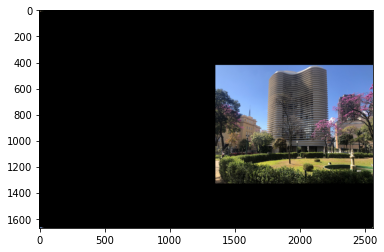

In [ ]:
plt.imshow(cv.cvtColor(im_dst_partial, cv.COLOR_BGRA2RGB))

<a name="mosaicos"></a>

## Mosaicos

### SIFT e Average Blending

### Set 1

In [ ]:
im_dst_partial,im_dst_final = stitch(imgs_set1[0],imgs_set1[1],imgs_set1[2],"sift","average")

In [ ]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(cv.cvtColor(im_dst_partial, cv.COLOR_BGRA2RGB))

In [ ]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(cv.cvtColor(im_dst_final, cv.COLOR_BGRA2RGB))

In [ ]:
download = Image.fromarray(cv.cvtColor(np.array(im_dst_final), cv.COLOR_BGR2RGB))
download.save("set1-avg-sift.jpg")

<img src="https://i.imgur.com/WMAaWlC.jpg">

### Set 2

In [ ]:
#Stitch second set
im_dst_set2_partial,im_dst_set2_final = stitch(imgs_set2[0],imgs_set2[1],imgs_set2[2],"sift","average")

In [ ]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(cv.cvtColor(im_dst_set2_partial, cv.COLOR_BGRA2RGB))

In [ ]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(cv.cvtColor(im_dst_set2_final, cv.COLOR_BGRA2RGB))

In [ ]:
download = Image.fromarray(cv.cvtColor(np.array(im_dst_set2_final), cv.COLOR_BGR2RGB))
download.save("set2-avg-sift.jpg")

<img src="https://i.imgur.com/uddXJ8G.jpg">

### Set 3

In [ ]:
#Stitch second set
im_dst_set3_partial,im_dst_set3_final = stitch(imgs_set3[0],imgs_set3[1],imgs_set3[2],"sift","average")

In [ ]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(cv.cvtColor(im_dst_set3_partial, cv.COLOR_BGRA2RGB))

In [ ]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(cv.cvtColor(im_dst_set3_final, cv.COLOR_BGRA2RGB))

In [ ]:
download = Image.fromarray(cv.cvtColor(np.array(im_dst_set3_final), cv.COLOR_BGR2RGB))
download.save("set3-avg-sift.jpg")

<img src="https://i.imgur.com/wImUEIg.jpg">

## SIFT e Feathering

### Set 1

In [ ]:
im_dst_partial,im_dst_final = stitch(imgs_set1[0],imgs_set1[1],imgs_set1[2],"sift","feathering")

In [ ]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(cv.cvtColor(im_dst_partial, cv.COLOR_BGRA2RGB))

In [ ]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(cv.cvtColor(im_dst_final, cv.COLOR_BGRA2RGB))

In [ ]:
download = Image.fromarray(cv.cvtColor(np.array(im_dst_final), cv.COLOR_BGR2RGB))
download.save("set1-feathering-sift.jpg")

<img src="https://i.imgur.com/ooa7Bwm.jpg">

### Set 2

In [ ]:
#Stitch second set
im_dst_set2_partial,im_dst_set2_final = stitch(imgs_set2[0],imgs_set2[1],imgs_set2[2],"sift","feathering")

In [ ]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(cv.cvtColor(im_dst_set2_partial, cv.COLOR_BGRA2RGB))

In [ ]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(cv.cvtColor(im_dst_set2_final, cv.COLOR_BGRA2RGB))

In [ ]:
download = Image.fromarray(cv.cvtColor(np.array(im_dst_set2_final), cv.COLOR_BGR2RGB))
download.save("set2-feathering-sift.jpg")

<img src="https://i.imgur.com/LiuEJcD.jpg">

### Set 3

In [ ]:
#Stitch second set
im_dst_set3_partial,im_dst_set3_final = stitch(imgs_set3[0],imgs_set3[1],imgs_set3[2],"sift","feathering")

In [ ]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(cv.cvtColor(im_dst_set3_partial, cv.COLOR_BGRA2RGB))

In [ ]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(cv.cvtColor(im_dst_set3_final, cv.COLOR_BGRA2RGB))

In [ ]:
download = Image.fromarray(cv.cvtColor(np.array(im_dst_set3_final), cv.COLOR_BGR2RGB))
download.save("set3-feathering-sift.jpg")

<img src="https://i.imgur.com/BYwAzK3.jpg">

## BRIEF e Average Blending

### Set 1

In [ ]:
im_dst_partial,im_dst_final = stitch(imgs_set1[0],imgs_set1[1],imgs_set1[2],"brief","average")

In [ ]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(cv.cvtColor(im_dst_partial, cv.COLOR_BGRA2RGB))

In [ ]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(cv.cvtColor(im_dst_final, cv.COLOR_BGRA2RGB))

In [ ]:
download = Image.fromarray(cv.cvtColor(np.array(im_dst_final), cv.COLOR_BGR2RGB))
download.save("set1-avg-brief.jpg")

<img src="https://i.imgur.com/lxpBeFg.jpg">

### Set 2

In [ ]:
#Stitch second set
im_dst_set2_partial,im_dst_set2_final = stitch(imgs_set2[0],imgs_set2[1],imgs_set2[2],"brief","average")

In [ ]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(cv.cvtColor(im_dst_set2_partial, cv.COLOR_BGRA2RGB))

In [ ]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(cv.cvtColor(im_dst_set2_final, cv.COLOR_BGRA2RGB))

In [ ]:
download = Image.fromarray(cv.cvtColor(np.array(im_dst_set2_final), cv.COLOR_BGR2RGB))
download.save("set2-avg-brief.jpg")

<img src="https://i.imgur.com/vjk2Feg.jpg">

### Set 3

In [ ]:
#Stitch second set
im_dst_set3_partial,im_dst_set3_final = stitch(imgs_set3[0],imgs_set3[1],imgs_set3[2],"brief","average")

In [ ]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(cv.cvtColor(im_dst_set3_partial, cv.COLOR_BGRA2RGB))

In [ ]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(cv.cvtColor(im_dst_set3_final, cv.COLOR_BGRA2RGB))

In [ ]:
download = Image.fromarray(cv.cvtColor(np.array(im_dst_set3_final), cv.COLOR_BGR2RGB))
download.save("set3-avg-brief.jpg")

<img src="https://i.imgur.com/C3IXbBT.jpg">

## BRIEF e Feathering

### Set 1

In [ ]:
im_dst_partial,im_dst_final = stitch(imgs_set1[0],imgs_set1[1],imgs_set1[2],"brief","feathering")

In [ ]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(cv.cvtColor(im_dst_partial, cv.COLOR_BGRA2RGB))

In [ ]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(cv.cvtColor(im_dst_final, cv.COLOR_BGRA2RGB))

In [ ]:
download = Image.fromarray(cv.cvtColor(np.array(im_dst_final), cv.COLOR_BGR2RGB))
download.save("set1-feathering-brief.jpg")

<img src="https://i.imgur.com/kUhKooD.jpg">

### Set 2

In [ ]:
#Stitch second set
im_dst_set2_partial,im_dst_set2_final = stitch(imgs_set2[0],imgs_set2[1],imgs_set2[2],"brief","feathering")

In [ ]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(cv.cvtColor(im_dst_set2_partial, cv.COLOR_BGRA2RGB))

In [ ]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(cv.cvtColor(im_dst_set2_final, cv.COLOR_BGRA2RGB))

In [ ]:
download = Image.fromarray(cv.cvtColor(np.array(im_dst_set2_final), cv.COLOR_BGR2RGB))
download.save("set2-feathering-brief.jpg")

<img src="https://i.imgur.com/XZEioAY.jpg">

### Set 3

In [ ]:
#Stitch second set
im_dst_set3_partial,im_dst_set3_final = stitch(imgs_set3[0],imgs_set3[1],imgs_set3[2],"brief","feathering")

In [ ]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(cv.cvtColor(im_dst_set3_partial, cv.COLOR_BGRA2RGB))

In [ ]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(cv.cvtColor(im_dst_set3_final, cv.COLOR_BGRA2RGB))

In [ ]:
download = Image.fromarray(cv.cvtColor(np.array(im_dst_set3_final), cv.COLOR_BGR2RGB))
download.save("set3-feathering-brief.jpg")

<img src="https://i.imgur.com/mqDnaAC.jpg">

<a name="resultados"></a>